## HEART ATTACK RISK PREDICTOR

In [1]:
# Importing required libraries 

import pandas as pd  # data processing, CSV file I/O (e.i. pd.read_csv)
import pandas_profiling as pp
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold,cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Feature Selection & Feature extraction
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA


#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier


# Stacking Models
from mlxtend.classifier import StackingCVClassifier

#Metrics & utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc #plot_roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Misc
import joblib  #import pickle
from time import time
from scipy import stats

import os
print('Current working directory')
print(os.getcwd())
print('')
print('Changed to working directory')
os.chdir(r'D:\SAPIENZA\ProceedIt\Flutter\dyHEALTH\github_proceedit\HAP_heart_attack_risk_predictor')
print(os.getcwd())

import sys
print()
print(sys.version)


Current working directory
C:\Users\alevi\DS_HOME\Proceedit\HAP

Changed to working directory
D:\SAPIENZA\ProceedIt\Flutter\dyHEALTH\github_proceedit\HAP_heart_attack_risk_predictor

3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]


In [7]:
project_path = r'D:\SAPIENZA\ProceedIt\Flutter\dyHEALTH\github_proceedit\HAP_heart_attack_risk_predictor'
files = ['cleveland_expanded_data','hungarian_expanded_data','longbeachva_expanded_data',\
         'switzerland_expanded_data']

def load_data(file,file_path=project_path):
    csvfile = os.path.join(file_path,file +'.csv')
    return pd.read_csv(csvfile)

In [3]:
cleve = load_data(files[0])
hung = load_data(files[1])
long = load_data(files[2])
switz = load_data(files[3])
total_df = pd.concat([cleve,hung,long,switz],ignore_index=True)
total_df.to_csv('total_df.csv')

print('TOTAL CONCATENATED DATASET SIZE : {}'.format(np.sum([cleve.shape[0],hung.shape[0],long.shape[0],switz.shape[0]])))
total_df.head()

TOTAL CONCATENATED DATASET SIZE : 899


,ID,CCF,AGE,SEX,PAINLOC,PAINEXER,RELREST,PNCADEN,CP,TRESTBPS,...,RCADIST,LVX1,LVX2,LVX3,LVX4,LVF,CATHEF,JUNK,Unnamed: 75,#REF!
0,1,0,63,1,-9,-9,-9,-9,1,145,...,1,1,1,1,1,1,-9.0,-9.0,name,NaN
1,2,0,67,1,-9,-9,-9,-9,4,160,...,1,1,1,1,1,1,-9.0,-9.0,name,NaN
2,3,0,67,1,-9,-9,-9,-9,4,120,...,2,1,1,1,7,3,-9.0,-9.0,name,NaN
3,4,0,37,1,-9,-9,-9,-9,3,130,...,1,1,1,1,1,1,-9.0,-9.0,name,NaN
4,6,0,41,0,-9,-9,-9,-9,2,130,...,1,1,1,1,1,1,-9.0,-9.0,name,NaN


In [9]:
# FUNCTION TO FILL WITH RANDOM VALUES FOR MISSING VALUES (-9's)
# np.random.randint(2,size = ch_copy_pre[col].value_counts().values[0]))

def fill_missing(value):
    
    for i in range(len(ch_copy_pre)):
        
        if value == -9: 
            value = np.random.choice(ch_copy_pre[ch_copy_pre[col] != -9][col])
            
        else:
            value = value
    
    return value

In [32]:
# PREPROCESSING DATAFRAME
# Experiment with Raw Data + SIX ML Classifiers 

#Feature Selection for Cleveland + Hungarian + Longbeach + switzerland Dataset

ch_copy_pre = total_dataset.copy()


print('Total Number of observations in our analysis [BEFORE] : {}'.format(len(ch_copy_pre)))
print('Total Number of columns Before Feature Selection      : {}'.format(len(ch_copy_pre.columns)))


# Pre-processing condition for variables

#  Dropping columns as mentioned in table-4 along with excluded features mentioned in the paper

column_names = ['ID','CCF','PAINLOC','PNCADEN','SMOKE','DM','FAMHIST','EKGMO','EKGDAY','EKGYR','DUMMY', \
                        'RESTCKM', 'EXERCKM','RESTEF','RESTWM', 'EXEREF', 'EXERWM','THALSEV', 'THALPUL', 'EARLPUL',\
                         'CMO', 'CDAY', 'CYR','LVX1', 'LVX2','LVX3', 'LVX4','LVF','RLDV5','DIAG','RAMUS','OM2',\
                          'CATHEF', 'JUNK','Unnamed: 75','#REF!']

ch_copy_pre = ch_copy_pre.drop(columns= column_names)

print('')
print('Number of columns dropped as described in the table-4 : {}'.format(len(column_names)))


# 1. target variable conversion to 0 & 1
ch_copy_pre['NUM'] = np.where((ch_copy_pre['NUM']>0),1,0)

# 2a. CONTINUOUS VARIABLES : Applying Imputation for data consistency 

ch_copy_pre['THALDUR'] = ch_copy_pre['THALDUR'].replace(-9,round((ch_copy_pre['THALDUR']!=-9).mean(),1))
ch_copy_pre['THALTIME'] = ch_copy_pre['THALTIME'].replace(-9,round((ch_copy_pre['THALTIME']!=-9).mean(),1))
ch_copy_pre['OLDPEAK'] = ch_copy_pre['OLDPEAK'].replace(-9,round((ch_copy_pre['OLDPEAK']!=-9).mean(),1))

ch_copy_pre['CHOL'] = ch_copy_pre['CHOL'].replace(0,int(ch_copy_pre['CHOL'].mean()))

# ch_copy_pre['THALTIME'] = ch_copy_pre['THALTIME'].replace(0,int(ch_copy_pre['THALTIME'].mean()))
ch_copy_pre['TRESTBPS'] = ch_copy_pre['TRESTBPS'].replace(0,int(ch_copy_pre['TRESTBPS'].mean()))
# ch_copy_pre['OLDPEAK'] = ch_copy_pre['OLDPEAK'].replace(0,int(ch_copy_pre['OLDPEAK'].mean()))
ch_copy_pre['YEARS'] = ch_copy_pre['YEARS'].replace(0,int(ch_copy_pre['YEARS'].mean()))
ch_copy_pre['CIGS'] = ch_copy_pre['CIGS'].replace(0,int(ch_copy_pre['CIGS'].mean()))


ch_copy_pre['PROTO'] = ch_copy_pre['PROTO'].apply(lambda x: 150 if x > 125 else x)

ch_copy_pre['PROTO'] = ch_copy_pre['PROTO'].map({-9:1,1:1,2:2,3:3,4:4,5:5,6:6,150:7,125:8,100:9,75:10,50:11,12:12,25:12})


# ch_copy_pre['PROTO'] = ch_copy_pre['PROTO'].replace(0,int((ch_copy_pre['PROTO']!=-9).mean()))


ch_copy_pre['OLDPEAK'] = ch_copy_pre['OLDPEAK'].apply(lambda x: np.abs(x) if x < 0 else x)

cont_col = ['CHOL','CIGS', 'YEARS','MET','THALACH','THALREST','TPEAKBPS','TRESTBPS','TPEAKBPD','TRESTBPD','RLDV5E']

for col in cont_col:
    ch_copy_pre[col] = ch_copy_pre[col].replace(-9,int(ch_copy_pre[col].mean()))
   
    

# 2b. CATEGORICAL VARIABLES : Applying Imputation for data consistency
# choosing unique label based on categories present
# [DANGER AREA WITH -9]

categ_col = ['SEX', 'PAINEXER', 'RELREST','HTN','FBS','DIG', 'PROP', 'NITR', 'PRO','DIURETIC','EXANG', 'XHYPO',\
            'LMT','LADPROX','LADDIST', 'CXMAIN', 'OM1', 'RCAPROX', 'RCADIST','RESTECG','SLOPE','CA','THAL']

for col in categ_col:
    ch_copy_pre[col] = ch_copy_pre[col].apply(fill_missing)
    

ch_copy_pre['SLOPE'] = ch_copy_pre['SLOPE'].apply(lambda x: 1 if x == 0 else x)
ch_copy_pre['CA'] = ch_copy_pre['CA'].apply(lambda x: 3 if x > 3 else x)
ch_copy_pre['THAL'] = ch_copy_pre['THAL'].apply(lambda x : 3 if x <=3 else (6 if (x > 3 and x <= 6) else x))

ch_copy_pre['LADPROX'] = np.where((ch_copy_pre['LADPROX']>1),1,0)
ch_copy_pre['LADDIST'] = np.where((ch_copy_pre['LADDIST']>1),1,0)
ch_copy_pre['CXMAIN'] = np.where((ch_copy_pre['CXMAIN']>1),1,0)
ch_copy_pre['OM1'] = np.where((ch_copy_pre['OM1']>1),1,0)
ch_copy_pre['RCAPROX'] = np.where((ch_copy_pre['RCAPROX']>1),1,0)

# 5. drop if Thaltime > thaldur
# 6. drop if thalach < thalrest
print('')
print('Total Number of rows dropped (where THALTIME > THALDUR) : {}'.format(len(ch_copy_pre[ch_copy_pre['THALTIME'] > ch_copy_pre['THALDUR']])))
ch_copy_pre = ch_copy_pre.drop(ch_copy_pre[ch_copy_pre['THALTIME'] > ch_copy_pre['THALDUR']].index)

print('Total Number of rows dropped (where THALACH < THALREST) : {}'.format(len(ch_copy_pre[ch_copy_pre['THALACH'] < ch_copy_pre['THALREST']])))
ch_copy_pre = ch_copy_pre.drop(ch_copy_pre[ch_copy_pre['THALACH'] < ch_copy_pre['THALREST']].index)

print('')

# 7. if oldpeak = 0 then convert thaltime = 0
ch_copy_pre.loc[(ch_copy_pre['OLDPEAK']==0),'THALTIME'] = 0


# resetting index

ch_copy_pre.reset_index(inplace=True)
ch_copy_pre.drop(columns='index',inplace=True)

print('')
print('Total Number of observations in our analysis [AFTER]  : {}'.format(len(ch_copy_pre)))
print('Total Number of columns After Feature Selection       : {}'.format(len(ch_copy_pre.columns)))

# saving the dataset as csv after feature selection
ch_copy_pre.to_csv('har_cleve_hung_longbeach_switz_reduced_preprocessed.csv')

ch_copy_pre.head()


Total Number of observations in our analysis [BEFORE] : 899
Total Number of columns Before Feature Selection      : 77

Number of columns dropped as described in the table-4 : 36

Total Number of rows dropped (where THALTIME > THALDUR) : 27
Total Number of rows dropped (where THALACH < THALREST) : 1


Total Number of observations in our analysis [AFTER]  : 871
Total Number of columns After Feature Selection       : 41


,AGE,SEX,PAINEXER,RELREST,CP,TRESTBPS,HTN,CHOL,CIGS,YEARS,...,CA,THAL,NUM,LMT,LADPROX,LADDIST,CXMAIN,OM1,RCAPROX,RCADIST
0,63,1,0,1,1,145,1,233,50,20,...,0,6,0,1,0,0,0,0,0,1
1,67,1,0,0,4,160,1,286,40,40,...,3,3,1,1,1,1,1,0,0,1
2,67,1,1,0,4,120,1,229,20,35,...,2,7,1,1,0,0,0,0,1,2
3,37,1,1,0,3,130,0,250,5,5,...,0,3,0,1,0,0,0,0,0,1
4,41,0,1,1,2,130,1,204,5,5,...,0,3,0,1,0,0,0,0,0,1


## CHI SQUARED ANALYSIS

In [33]:
from sklearn.feature_selection import SelectKBest,chi2
from scipy import stats

#Preparing the data for ChiSquared statistical analysis 

chi_X = ch_copy_pre.drop('NUM',axis=1)
chi_y = ch_copy_pre['NUM']

# Convert to categorical data by converting data to integers
# X = X.astype(int)

# Select 22 features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=22)
chi2_selector.fit_transform(chi_X,chi_y)


# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(ch_copy_pre.columns, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['Feature', 'ChiScore', 'P-value'])
chi2_scores

# you can see that the kbest returned from SelectKBest 
#+ were the features with the _highest_ score
kbest = np.asarray(chi_X.columns)[chi2_selector.get_support()]
kbest

array(['AGE', 'PAINEXER', 'RELREST', 'CP', 'CIGS', 'YEARS', 'THALDUR',
       'THALTIME', 'MET', 'THALACH', 'THALREST', 'TPEAKBPS', 'EXANG',
       'OLDPEAK', 'RLDV5E', 'THAL', 'LMT', 'LADPROX', 'LADDIST', 'CXMAIN',
       'OM1', 'RCAPROX'], dtype=object)

P-VALUES
     Feature     ChiScore        P-value
0        AGE   118.126957   1.626376e-27
1        SEX    19.080684   1.253067e-05
2   PAINEXER    39.278761   3.674162e-10
3    RELREST    21.744642   3.114585e-06
4         CP    50.998725   9.242597e-13
5   TRESTBPS    32.074769   1.483515e-08
6        HTN     1.997721   1.575359e-01
7       CHOL     0.225823   6.346383e-01
8       CIGS   110.743419   6.734671e-26
9      YEARS   123.216924   1.250069e-28
10       FBS    12.031011   5.232268e-04
11   RESTECG     3.505677   6.115885e-02
12       DIG     0.420592   5.166416e-01
13      PROP    24.338587   8.080409e-07
14      NITR    32.379682   1.268054e-08
15       PRO    21.877912   2.905593e-06
16  DIURETIC     7.208267   7.256853e-03
17     PROTO     2.600797   1.068100e-01
18   THALDUR   141.671908   1.147152e-32
19  THALTIME   143.086582   5.627301e-33
20       MET  2629.355261   0.000000e+00
21   THALACH   607.066071  4.862810e-134
22  THALREST   105.559056   9.211143e-25
23  TPE

<AxesSubplot:>

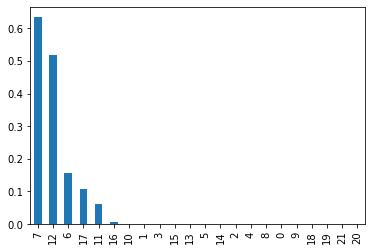

In [28]:
print('P-VALUES')
print(chi2_scores)
print('')
print('PLOTTING P-VALUES')
chi2_scores['P-value'][0:22].sort_values(ascending = False).plot.bar()

In [23]:
chi2_scores

,Feature,ChiScore,P-value
0,AGE,118.126957,1.626376e-27
1,SEX,19.080684,1.253067e-05
2,PAINEXER,47.383926,5.835928e-12
3,RELREST,28.686790,8.508215e-08
4,CP,50.998725,9.242597e-13
5,TRESTBPS,35.827969,2.155314e-09
6,HTN,2.157505,1.418749e-01
7,CHOL,0.225823,6.346383e-01
8,CIGS,156.100227,8.049441e-36
9,YEARS,170.507259,5.732935e-39


In [43]:
# # ChiSquared Analysis USING SCIPY 
# # Performing chisquare for individual features 

# observed_table = pd.crosstab(ch_copy_pre['LADDIST'],ch_copy_pre['NUM'],margins=True)

# def contingency_comparision(cross_table,confidence_interval):
#     chi_value, p , dof , expected_values = stats.chi2_contingency(cross_table)
#     print('Chisquare_statistic value :{}'.format(chi_value))
#     print('P-value is : {}'.format(p))
#     alpha = 1.0 - confidence_interval
    
#     if p <= alpha:
#         print('Features are Dependent [Reject H0]')
#     else:
#         print('Features are independent [Fail to Reject H0]')
    
#     return expected_values

# exp_contingency_table = contingency_comparision(observed_table,0.95)
# print(exp_contingency_table)

Chisquare_statistic value :160.08521277681396
P-value is : 5.680684256538077e-32
Features are Dependent [Reject H0]
[[143.4  95.6 239. ]
 [ 54.   36.   90. ]
 [147.6  98.4 246. ]
 [345.  230.  575. ]]


In [34]:
## working with features that are identified by ChiSquare + Few Additional features

# 22 features 
subset_ch_copy_pre = ch_copy_pre[['CHOL','CP','CIGS','YEARS','PAINEXER','RELREST','RESTECG','PROTO','OLDPEAK','CXMAIN','CA',\
                                  'THALDUR','THAL','THALTIME','LADDIST','RCAPROX','LADPROX',
                                  'EXANG','THALACH','SLOPE', 'RLDV5E','OM1','NUM']]

subset_ch_copy_pre.to_csv('subset_ch_copy.csv',index=False)
subset_ch_copy_pre.corr()

,CHOL,CP,CIGS,YEARS,PAINEXER,RELREST,RESTECG,PROTO,OLDPEAK,CXMAIN,...,THALTIME,LADDIST,RCAPROX,LADPROX,EXANG,THALACH,SLOPE,RLDV5E,OM1,NUM
CHOL,1.000000,0.022291,-0.044566,0.011270,0.051552,0.016646,0.097594,-0.078394,0.039517,0.077123,...,0.090416,0.034133,0.061999,0.004592,0.034241,0.069304,-0.020455,0.085047,0.056778,-0.004402
CP,0.022291,1.000000,0.094421,0.090681,0.544474,0.545242,0.038058,-0.006451,0.239752,0.154131,...,0.109806,0.149242,0.116285,0.187538,0.401834,-0.336900,0.135574,-0.034267,0.091219,0.470125
CIGS,-0.044566,0.094421,1.000000,0.609395,0.052653,0.110802,0.130624,-0.359429,0.057876,-0.018425,...,-0.056318,-0.062482,-0.001783,-0.073199,0.089525,0.020806,-0.083420,0.216741,0.009801,0.093193
YEARS,0.011270,0.090681,0.609395,1.000000,0.079369,0.132119,0.141435,-0.423939,0.097226,-0.006822,...,-0.039617,-0.069287,-0.013752,-0.055631,0.103305,-0.034926,-0.073366,0.186690,0.042778,0.108796
PAINEXER,0.051552,0.544474,0.052653,0.079369,1.000000,0.437766,0.038296,-0.009594,0.192793,0.084561,...,0.096118,0.086062,0.071954,0.130272,0.283446,-0.218914,0.069136,0.020736,0.008754,0.348973
RELREST,0.016646,0.545242,0.110802,0.132119,0.437766,1.000000,0.067486,-0.078543,0.205888,0.110611,...,0.066018,0.044510,0.065752,0.129285,0.241824,-0.188822,0.098339,-0.004056,0.047099,0.353003
RESTECG,0.097594,0.038058,0.130624,0.141435,0.038296,0.067486,1.000000,-0.361761,0.113632,-0.059165,...,-0.025084,-0.029615,-0.007375,-0.060782,0.030562,0.045722,-0.031086,0.289827,0.044882,0.061318
PROTO,-0.078394,-0.006451,-0.359429,-0.423939,-0.009594,-0.078543,-0.361761,1.000000,-0.159631,0.176352,...,-0.066988,0.118218,0.219132,0.255630,0.053512,-0.251893,0.168855,-0.576153,0.013223,0.029014
OLDPEAK,0.039517,0.239752,0.057876,0.097226,0.192793,0.205888,0.113632,-0.159631,1.000000,0.128978,...,0.464494,0.162788,0.173789,0.148495,0.394034,-0.171177,0.303592,0.167670,0.148052,0.399659
CXMAIN,0.077123,0.154131,-0.018425,-0.006822,0.084561,0.110611,-0.059165,0.176352,0.128978,1.000000,...,0.045488,0.170629,0.203457,0.154506,0.191818,-0.223159,0.143627,-0.171725,0.088388,0.360514


In [14]:
def check_missing_duplicated(data):
    # checking NA and Missing values
    print('Number of NA\'s in the dataset')
    print(data.isna().sum())
    print('')
    print('Total missing values in the dataset')
    print(data.isnull().sum())

    # check for duplicates

    print('')
    print('Number of duplicates')
    print(data.duplicated().sum())
    duplicate_data = data[data.duplicated(keep=False)].sort_values(by=['CHOL'], ascending= False) 
    duplicate_data.head()
    
    # dropping duplicates
    data.drop_duplicates(inplace=True)
    print('Duplicates count after dropping : {}'.format(data.duplicated().sum()))
    print('Number of observations after dropping duplicates : {}'.format(len(data)))
    
check_missing_duplicated(subset_ch_copy_pre)

Number of NA's in the dataset
CHOL        0
CP          0
CIGS        0
YEARS       0
PAINEXER    0
RELREST     0
RESTECG     0
PROTO       0
OLDPEAK     0
CXMAIN      0
CA          0
THALDUR     0
THAL        0
THALTIME    0
LADDIST     0
RCAPROX     0
LADPROX     0
EXANG       0
THALACH     0
SLOPE       0
RLDV5E      0
OM1         0
NUM         0
dtype: int64

Total missing values in the dataset
CHOL        0
CP          0
CIGS        0
YEARS       0
PAINEXER    0
RELREST     0
RESTECG     0
PROTO       0
OLDPEAK     0
CXMAIN      0
CA          0
THALDUR     0
THAL        0
THALTIME    0
LADDIST     0
RCAPROX     0
LADPROX     0
EXANG       0
THALACH     0
SLOPE       0
RLDV5E      0
OM1         0
NUM         0
dtype: int64

Number of duplicates
0
Duplicates count after dropping : 0
Number of observations after dropping duplicates : 871


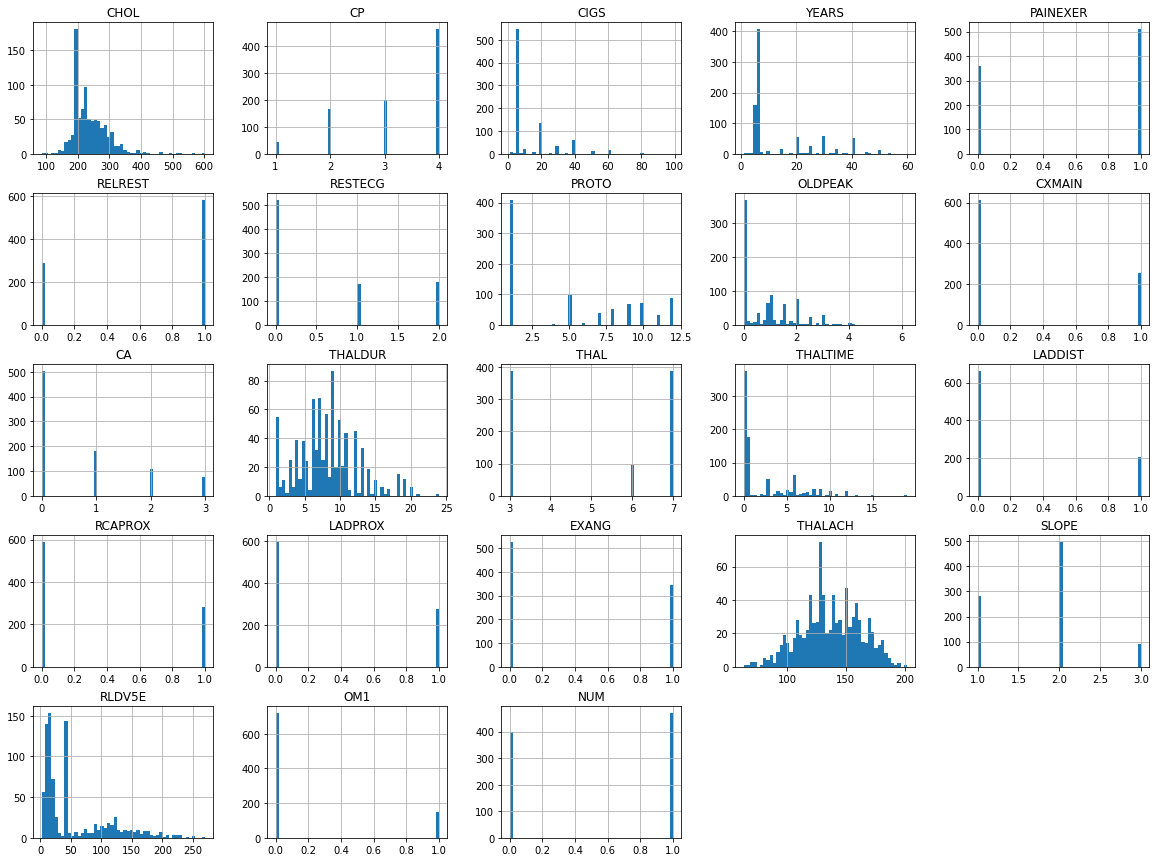

In [38]:
%matplotlib inline 
subset_ch_copy_pre.hist(bins=50,figsize=(20,15))
plt.savefig('features_distribution.png')
plt.show()

### CORRELATION HEATMAP

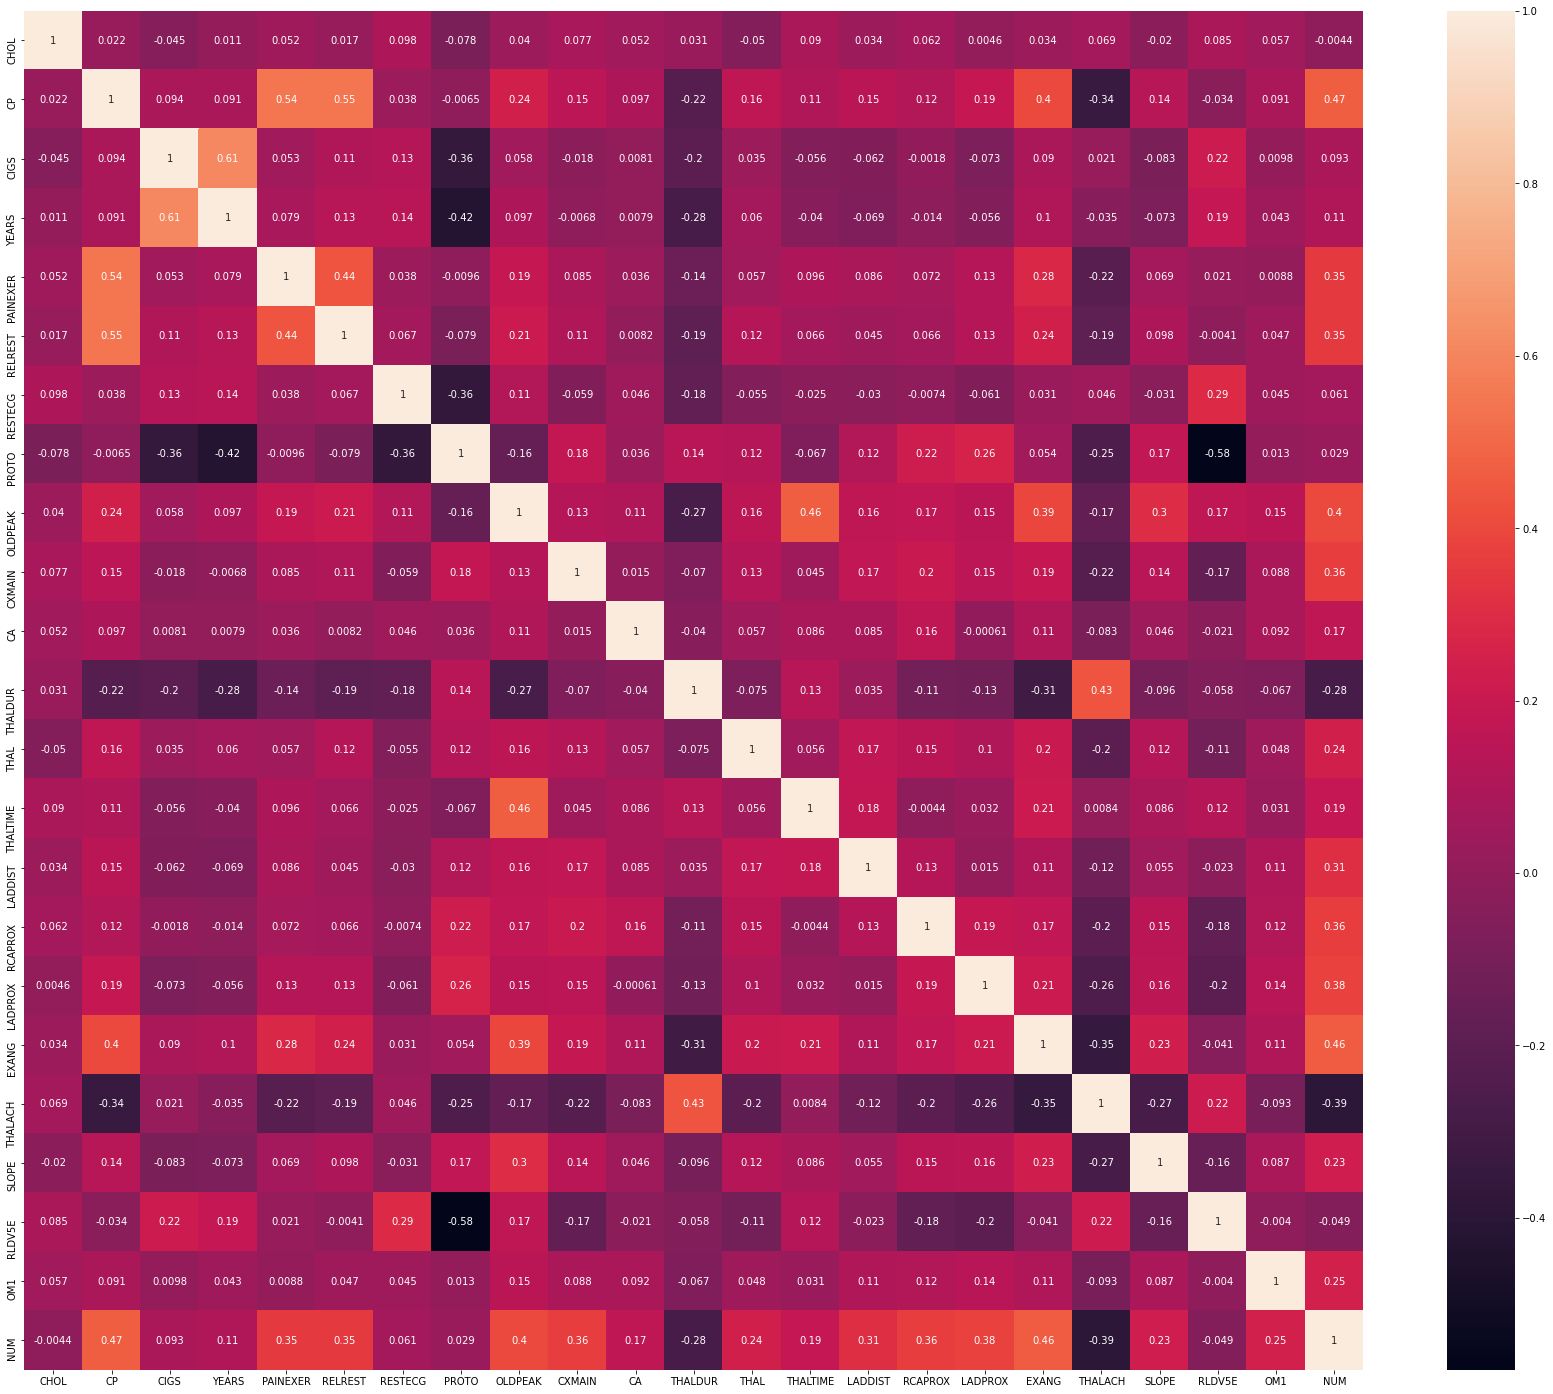

In [36]:
# correlation among identified features 

plt.figure(figsize=(30,25))
sns.heatmap(subset_ch_copy_pre.corr(),annot=True)
plt.savefig('correlation_11.png')
plt.show()

### TOP 5 CORRELATION PAIRS

In [18]:
# map features to their absolute correlation values
corr_matrix = subset_ch_copy_pre.corr().unstack()

# set equality (self correlation) as zero
corr_matrix[corr_matrix == 1] = 0

# of each feature, find the max correlation
# and sort the resulting array in ascending order
corr = corr_matrix.sort_values(ascending=False)

column_name = {0:'Pearson Coefficient'}
corr = pd.DataFrame(corr,columns=column_name)
corr.rename(columns=column_name,inplace=True)

corr.head(10)

# display the highly correlated features
# display(corr[corr > 0.8])

Pearson Coefficient
CIGS     YEARS                0.655207
YEARS    CIGS                 0.655207
RELREST  CP                   0.537423
CP       RELREST              0.537423
         PAINEXER             0.526324
PAINEXER CP                   0.526324
CP       NUM                  0.470125
NUM      CP                   0.470125
THALTIME OLDPEAK              0.464494
OLDPEAK  THALTIME             0.464494

## PCA 

In [44]:
# Feature Extraction using PCA 
# k = 11 as described in the paper


#Preparing the data for PCA analysis 

pca_X = subset_ch_copy_pre.drop('NUM',axis=1)
pca_y = subset_ch_copy_pre['NUM']


# Scaling the Data and Creating the array
scaler = StandardScaler()

pca_X = scaler.fit_transform(pca_X.values)
pca_y = pca_y.values

# covariance matrix
pca_cov_matrix = PCA(n_components=22)

# calculate eigen values
pca_cov_matrix.fit(pca_X)
X_pc = pca_cov_matrix.transform(pca_X)

variance_ratio = pca_cov_matrix.explained_variance_ratio_
var=np.cumsum(np.round(variance_ratio,3)*100)


print('Features with Eigen value One Criteria')
print(pca_cov_matrix.explained_variance_)

print('-------')
print('Cumulative sum of variance explained with [n] features')
print(var)


# number of components
pca_components = pca_cov_matrix.n_components_

# get the index of the most important feature on EACH component

most_important = [np.abs(pca_cov_matrix.components_[i]).argmax() for i in range(pca_components)]

# print(most_important)

initial_feature_names = subset_ch_copy_pre.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca_components)]

print('-------')
print('Variance explained with feature names')
print(most_important_names)

# Dictionary of PCA Components with Features
dic = {'PC{}'.format(i): most_important_names[i] for i in range(pca_components)}

# build the dataframe with component and feature name (best feature of each component)
df = pd.DataFrame(dic.items(),columns=['COMPONENT','FEATURE'])

# DATASET after PCA

# Reduced dataset after applying PCA 
pca_df = pd.DataFrame(X_pc,columns=dic.keys())

pca_df['LABEL'] = subset_ch_copy_pre['NUM']

pca_df.to_csv('pca_df.csv')
print('')
print('Number rows dropping : {}'.format(len(pca_df[pca_df['LABEL'].isna()].index)))

pca_df = pca_df.drop(pca_df[pca_df['LABEL'].isna()].index)

Features with Eigen value One Criteria
[3.53036115 2.73266913 1.63756656 1.40613713 1.15725171 1.15389458
 1.00592093 0.94658066 0.93628115 0.83757281 0.8137388  0.79777095
 0.7257712  0.68695913 0.621274   0.59624444 0.53795741 0.48895664
 0.40080473 0.3836903  0.32350172 0.30438225]
-------
Cumulative sum of variance explained with [n] features
[16.  28.4 35.8 42.2 47.5 52.7 57.3 61.6 65.9 69.7 73.4 77.  80.3 83.4
 86.2 88.9 91.3 93.5 95.3 97.  98.5 99.9]
-------
Variance explained with feature names
['CP', 'PROTO', 'THALTIME', 'PAINEXER', 'SLOPE', 'CHOL', 'CA', 'LADDIST', 'OM1', 'THAL', 'SLOPE', 'RCAPROX', 'CXMAIN', 'LADPROX', 'EXANG', 'RLDV5E', 'PAINEXER', 'THALACH', 'CIGS', 'CP', 'OLDPEAK', 'PROTO']

Number rows dropping : 0


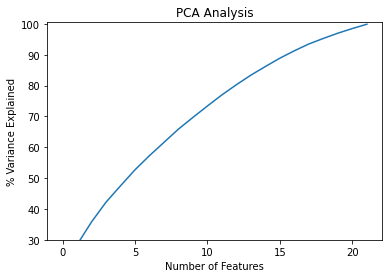

In [47]:
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.savefig('pca_analysis.png')
# plt.savefig('correlation_11.png')
plt.plot(var)
plt.show()

In [14]:
pca_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,LABEL
0,-1.200454,3.051796,1.404623,1.714154,-1.821819,-0.761178,0.389932,-0.272953,-0.059998,-0.680825,...,1.040616,0.075363,0.546730,-0.209745,1.077441,2.329998,0.231422,0.352619,0.616986,0
1,2.605635,2.944036,1.215685,1.270541,1.699748,-0.028711,0.571018,-1.153299,1.685128,0.706884,...,1.177233,-0.017487,-0.521512,1.297044,1.042232,0.639717,-0.447966,0.433673,-0.342282,1
2,2.199369,2.854651,1.189619,0.658545,-0.000235,-0.054552,-0.225160,-0.354604,0.984981,-0.415973,...,-0.837779,-0.652709,0.065822,0.515870,0.366955,0.279283,-0.737475,0.258450,-0.906704,1
3,-0.412577,1.383798,4.481603,-1.620857,-1.545754,-1.615855,0.737980,0.637842,0.925103,-0.925664,...,0.262766,1.237891,0.148337,-0.240769,-0.279637,0.374941,0.293292,-0.192704,-0.314766,0
4,-2.488001,0.966431,0.491131,-0.797064,-1.092300,1.257678,-0.182467,-0.034121,-0.459333,-0.900481,...,-0.411334,-0.662144,0.211776,-1.875393,-0.669293,0.301954,-0.142452,0.611871,0.339910,0


### SPLITTING THE DATA INTO TRAINING & TEST DATASETS
#### Raw Data

In [39]:
# input data 
X = subset_ch_copy_pre.drop('NUM',axis=1)
y = subset_ch_copy_pre['NUM']


Xx = X.values
yy = y.values


# Scaling the Data and Creating the array
normalize = MinMaxScaler()
scaler = StandardScaler()

X = normalize.fit_transform(X.values)
X = scaler.fit_transform(X)

# X = scaler.fit_transform(X.values)

y = y.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,stratify=y,test_size=0.2,random_state=103)

print('TRAINING SIZE : {}'.format(Xtrain.shape))

print('TESTING SIZE : {}'.format(Xtest.shape))

TRAINING SIZE : (696, 22)
TESTING SIZE : (175, 22)


#### PCA Input

In [15]:
# PCA Input data 
pc_X = pca_df.drop('LABEL',axis=1)
pc_y = pca_df['LABEL']


# Scaling the Data and Creating the array
# scaler = StandardScaler()

pc_X = scaler.fit_transform(pc_X.values)
pc_y = pc_y.values


Xtrain, Xtest, ytrain, ytest = train_test_split(pc_X,pc_y,stratify=pc_y,test_size=0.2,random_state=103)

print('TRAINING SIZE : {}'.format(Xtrain.shape))

print('TESTING SIZE : {}'.format(Xtest.shape))

TRAINING SIZE : (696, 22)
TESTING SIZE : (175, 22)


Most of the ensemble models have a parameter called predict_proba, which allows the output of the most significant features of the model based on their probability through majority vote via either the gini index or entropy. These top 5 variables showed up in all of these Variable Importance Plots:

- Exercise Max Heart Rate Achieved
- Major Vessels F. Colored: 0
- ST depression induced by Exercise relative to Rest
- Thalassemia: reversable defect
- Thalassemia: normal

## LOGISTIC REGRESSION

In [43]:
def logistic_regression(Xtrain,ytrain,Xtest,ytest):
    logit = LogisticRegression(C=1.5,penalty='l2',fit_intercept=True)
    logit.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(logit.score(Xtest,ytest)))
    y_logit_pred = logit.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_logit_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_logit_pred))

In [44]:
logistic_regression(Xtrain,ytrain,Xtest,ytest)

ACCURACY OF THE MODEL : 0.8521739130434782

CONFUSION MATRIX
[[65  4]
 [13 33]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.83      0.94      0.88        69
           1       0.89      0.72      0.80        46

    accuracy                           0.85       115
   macro avg       0.86      0.83      0.84       115
weighted avg       0.86      0.85      0.85       115



## DECISION TREE CLASSIFIER

In [84]:
def decision_tree(Xtrain,ytrain,Xtest,ytest):
    Dtree =  DecisionTreeClassifier()
    Dtree.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(Dtree.score(Xtest,ytest)))
    y_dt_pred = Dtree.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_dt_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_dt_pred))
    

decision_tree(Xtrain,ytrain,Xtest,ytest)    

ACCURACY OF THE MODEL : 0.8685714285714285

CONFUSION MATRIX
[[69 11]
 [12 83]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        80
           1       0.88      0.87      0.88        95

    accuracy                           0.87       175
   macro avg       0.87      0.87      0.87       175
weighted avg       0.87      0.87      0.87       175



## RANDOM FOREST CLASSIFIER

In [83]:
def random_forest(Xtrain,ytrain,Xtest,ytest):
    RForest = RandomForestClassifier(n_estimators=500,max_features=0.25,criterion='entropy')
    RForest.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(RForest.score(Xtest,ytest)))
    y_rf_pred = RForest.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_rf_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_rf_pred))
    print('')
    print('FEATURE IMPORTANCE')
    print(RForest.feature_importances_)
    
random_forest(Xtrain,ytrain,Xtest,ytest)

ACCURACY OF THE MODEL : 0.9257142857142857

CONFUSION MATRIX
[[73  7]
 [ 6 89]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.92      0.91      0.92        80
           1       0.93      0.94      0.93        95

    accuracy                           0.93       175
   macro avg       0.93      0.92      0.93       175
weighted avg       0.93      0.93      0.93       175


FEATURE IMPORTANCE
[0.06572971 0.10228314 0.02551826 0.02637418 0.02161936 0.01444837
 0.05501819 0.07951736 0.05552587 0.02112278 0.0512736  0.02391612
 0.04109908 0.0551804  0.05009141 0.0678178  0.05235703 0.07409239
 0.02116348 0.07071008 0.02514138]


## SUPPORT VECTOR CLASSIFIER

In [80]:
def support_vector(Xtrain,ytrain,Xtest,ytest):
    SVector = SVC(C=0.01,gamma=0.1,kernel="poly",degree=3,coef0=10.0)
    SVector.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(SVector.score(Xtest,ytest)))
    y_sv_pred = SVector.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_sv_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_sv_pred))
    
support_vector(Xtrain,ytrain,Xtest,ytest)

ACCURACY OF THE MODEL : 0.9371428571428572

CONFUSION MATRIX
[[76  4]
 [ 7 88]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.92      0.95      0.93        80
           1       0.96      0.93      0.94        95

    accuracy                           0.94       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



### K-Nearest Neighbors

In [71]:
def k_nearest(Xtrain,ytrain,Xtest,ytest):
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(neigh.score(Xtest,ytest)))
    y_kn_pred = neigh.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_kn_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_kn_pred))
    
k_nearest(Xtrain,ytrain,Xtest,ytest)    

ACCURACY OF THE MODEL : 0.8857142857142857

CONFUSION MATRIX
[[73  7]
 [13 82]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        80
           1       0.92      0.86      0.89        95

    accuracy                           0.89       175
   macro avg       0.89      0.89      0.89       175
weighted avg       0.89      0.89      0.89       175



## NEURAL NETWORK - MLP CLASSIFIER

In [70]:
def neural_classifier(Xtrain,ytrain,Xtest,ytest):
    nn_model = MLPClassifier(hidden_layer_sizes=(10,50,100,50,10), activation='relu',
                         learning_rate='constant',solver='adam')
    nn_model.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(nn_model.score(Xtest,ytest)))
    y_mlp_pred = nn_model.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_mlp_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_mlp_pred))
    
neural_classifier(Xtrain,ytrain,Xtest,ytest)

ACCURACY OF THE MODEL : 0.9085714285714286

CONFUSION MATRIX
[[73  7]
 [ 9 86]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        80
           1       0.92      0.91      0.91        95

    accuracy                           0.91       175
   macro avg       0.91      0.91      0.91       175
weighted avg       0.91      0.91      0.91       175



## NAIVE_BAYES CLASSIFIER

In [69]:
def naive_bayes(Xtrain,ytrain,Xtest,ytest):
    nb_model = GaussianNB()
    nb_model.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(nb_model.score(Xtest,ytest)))
    y_nb_pred = nb_model.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_nb_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_nb_pred))

naive_bayes(Xtrain,ytrain,Xtest,ytest)

ACCURACY OF THE MODEL : 0.8628571428571429

CONFUSION MATRIX
[[69 11]
 [13 82]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        80
           1       0.88      0.86      0.87        95

    accuracy                           0.86       175
   macro avg       0.86      0.86      0.86       175
weighted avg       0.86      0.86      0.86       175



### GradientBoosting 

In [68]:
def gradient_boosting(Xtrain,ytrain,Xtest,ytest):
    GBC = GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.1,n_estimators=500,max_depth=3,max_features='log2')
    GBC.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(GBC.score(Xtest,ytest)))
    y_gbc_pred = GBC.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest,y_gbc_pred)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,y_gbc_pred))
    
gradient_boosting(Xtrain,ytrain,Xtest,ytest)

ACCURACY OF THE MODEL : 0.9485714285714286

CONFUSION MATRIX
[[76  4]
 [ 5 90]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.94      0.95      0.94        80
           1       0.96      0.95      0.95        95

    accuracy                           0.95       175
   macro avg       0.95      0.95      0.95       175
weighted avg       0.95      0.95      0.95       175



## Extreme Gradient Boosting

In [67]:
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

def xgb_classifier(Xtrain,ytrain,Xtest,ytest):
    xgba = XGBClassifier()
    grid = GridSearchCV(xgba,
                    parameters, n_jobs=4,
                    scoring="accuracy",
                    cv=3)
    grid.fit(Xtrain,ytrain)
    print('ACCURACY OF THE MODEL : {}'.format(grid.score(Xtest,ytest)))
    xgba_predicted = grid.predict(Xtest)
    confusionMatrix = confusion_matrix(ytest, xgba_predicted)
    xgba_acc_score = accuracy_score(ytest, xgba_predicted)
    print('')
    print('CONFUSION MATRIX')
    print(confusionMatrix)
    print('')
    print("ACCURACY OF EXTREME GRADIENT BOOST : {}".format(xgba_acc_score*100))
    print('')
    print('CLASSIFICATION REPORT')
    print(classification_report(ytest,xgba_predicted))
    
xgb_classifier(Xtrain,ytrain,Xtest,ytest) 

confussion matrix
[[74  6]
 [ 5 90]]


Accuracy of Extreme Gradient Boost: 93.71428571428572 

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        80
           1       0.94      0.95      0.94        95

    accuracy                           0.94       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



## STACKING MODELS 

In [40]:
# stacking models with hyperparameter tuning

def stacked_model():
    
    # BASE MODELS
    
    dt  = DecisionTreeClassifier(criterion='entropy')
    
    rfc =  RandomForestClassifier(n_estimators=500,max_features=0.25,criterion='entropy')
    
    gbc = GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.1,n_estimators=500,max_depth=3,max_features='log2')
    
    nb = GaussianNB()
    
    svc = SVC(kernel='poly',C=0.01,gamma=0.1,degree=3,coef0=10.0)
    
    mlp = MLPClassifier(hidden_layer_sizes=(10,50,100,50,10), activation='relu',learning_rate='constant',solver='adam')
    
    xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
    
    
    # META MODEL
    # for classification problem by default the metamodel is LR, for Regression it is Linear Regression
    
    metamodel = LogisticRegression(C=1.5,penalty='l2',fit_intercept=True)
    
    
    # STACKING OF CLASSIFIERS

    model = StackingCVClassifier(classifiers=[dt,rfc,gbc,mlp,nb,svc,xgb],meta_classifier=metamodel,random_state=42)
    
    return model
    

In [41]:
# create a dictionary for models

def loading_models():
    models = dict()
    models['Logistic Regression'] = LogisticRegression(C=1.5,penalty='l2',fit_intercept=True)
    models['k-Nearest'] = KNeighborsClassifier()
    models['Decision Tree'] = DecisionTreeClassifier()
    models['Random Forest'] = RandomForestClassifier(n_estimators=500,max_features=0.25,criterion='entropy')
    models['Support Vector'] = SVC(C=0.01,gamma=0.1,kernel="poly",degree=3,coef0=10.0)
    models['Naive Bayes']  = GaussianNB()
    models['Gradient Boosting'] =  GradientBoostingClassifier(loss = 'deviance',learning_rate = 0.1,n_estimators=500,max_depth=3,max_features='log2')
    models['MultiLayer Perceptron'] = MLPClassifier(hidden_layer_sizes=(10,50,100,50,10), activation='relu',
                         learning_rate='constant',solver='adam')
    models['Xtreme Gradient'] = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)

    models['Stacked Model'] = stacked_model()
    return models

In [42]:
# evaluate the models using cross-validation
from sklearn.model_selection import cross_validate

def evaluating_model(model,X,y):
    scoring = ['accuracy','precision','recall','f1']
    cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)
    scores = cross_validate(model,X,y,cv=cv,scoring=scoring,n_jobs=-1,error_score='raise')
    return scores

In [18]:
# Results: Experiment with  raw data + Six ML Classifiers [Features from Paper]

models = loading_models()

# evaluate the  models and store the results
results,names = list(),list()

for name,model in tqdm(models.items()):

    scores = evaluating_model(model,X,y)
    results.append(scores)
    names.append(name)

    
# Final Results
      
results_df = pd.DataFrame(columns=['ACCURACY(%)','PRECISION(%)','RECALL(%)','F1_SCORE(%)'],)

for dic,name in zip(results,names):
    accuracy = np.mean((dic['test_accuracy']*100))
    precision = np.mean(dic['test_precision']*100)
    recall = np.mean(dic['test_recall']*100)
    f1_score = np.mean(dic['test_f1']*100)
    
    results_df.loc[name] = [accuracy,precision,recall,f1_score]

# results_df.to_csv('results_df1.csv')
results_df.round(1)

  0%|          | 0/10 [00:00<?, ?it/s]

,ACCURACY(%),PRECISION(%),RECALL(%),F1_SCORE(%)
Logistic Regression,87.6,89.5,87.7,88.4
k-Nearest,86.5,93.7,80.6,86.5
Decision Tree,86.5,87.3,88.4,87.7
Random Forest,90.9,92.1,91.3,91.6
Support Vector,92.2,94.1,91.4,92.7
Naive Bayes,86.4,87.1,88.2,87.5
Gradient Boosting,94.0,95.3,93.5,94.4
MultiLayer Perceptron,86.1,87.9,86.5,87.1
Xtreme Gradient,87.3,88.9,87.6,88.1
Stacked Model,93.5,94.4,93.6,93.9


In [43]:
# Results: Experiment with  raw data + Six ML Classifiers [Features from Paper]  -----PCA

models = loading_models()

# evaluate the  models and store the results
results,names = list(),list()

for name,model in tqdm(models.items()):

    scores = evaluating_model(model,X,y)
    results.append(scores)
    names.append(name)

    
# Final Results
      
results_df = pd.DataFrame(columns=['ACCURACY(%)','PRECISION(%)','RECALL(%)','F1_SCORE(%)'],)

for dic,name in zip(results,names):
    accuracy = np.mean((dic['test_accuracy']*100))
    precision = np.mean(dic['test_precision']*100)
    recall = np.mean(dic['test_recall']*100)
    f1_score = np.mean(dic['test_f1']*100)
    
    results_df.loc[name] = [accuracy,precision,recall,f1_score]

# results_df.to_csv('results_df1.csv')
results_df.round(1)

  0%|          | 0/10 [00:00<?, ?it/s]

,ACCURACY(%),PRECISION(%),RECALL(%),F1_SCORE(%)
Logistic Regression,86.3,88.0,86.7,87.2
k-Nearest,85.6,92.7,80.0,85.7
Decision Tree,86.6,87.9,87.7,87.7
Random Forest,91.2,93.4,90.4,91.8
Support Vector,90.9,93.2,89.9,91.4
Naive Bayes,86.3,86.9,88.3,87.5
Gradient Boosting,91.8,93.7,91.2,92.3
MultiLayer Perceptron,85.2,86.4,86.4,86.3
Xtreme Gradient,87.5,89.8,87.2,88.3
Stacked Model,91.8,93.3,91.7,92.4


### FINALIZING THE MODEL
#### Training on Whole Dataset

In [61]:
# Model Performance on the Test data
# Picked only the final estimator after stacking is performed
stackedModel = stacked_model()
stackedModel.fit(Xtrain,ytrain)
print('Final stacked Model Accuracy : {:0.2f} %'.format(stackedModel.score(Xtest,ytest)*100))

Final stacked Model Accuracy : 95.43 %


## CONFUSION MATRIX

In [20]:
y_stacked_pred = stackedModel.predict(Xtest)

confusionMatrix = confusion_matrix(ytest,y_stacked_pred)
print('Confusion Matrix')
print(confusionMatrix)
print()
print('TEST DATASET SIZE : {}'.format(len(Xtest)))
print('')
print('TRUE POSITIVIES  : {}'.format(confusionMatrix[1][1]))
print('FALSE POSITIVIES : {}'.format(confusionMatrix[0][1]))
print('TRUE NEGATIVES   : {}'.format(confusionMatrix[0][0]))
print('FALSE NEGATIVES  : {}'.format(confusionMatrix[1][0]))

print()
print('Classification Report')
print()
classNames = ['No Disease', 'Disease']
print(classification_report(ytest,y_stacked_pred, target_names=classNames))


Confusion Matrix
[[73  7]
 [ 4 91]]

TEST DATASET SIZE : 175

TRUE POSITIVIES  : 91
FALSE POSITIVIES : 7
TRUE NEGATIVES   : 73
FALSE NEGATIVES  : 4

Classification Report

              precision    recall  f1-score   support

  No Disease       0.95      0.91      0.93        80
     Disease       0.93      0.96      0.94        95

    accuracy                           0.94       175
   macro avg       0.94      0.94      0.94       175
weighted avg       0.94      0.94      0.94       175



## SAVING THE MODEL
### using joblib

In [63]:
# saving the model to use it in applications
import joblib
HeartRiskModel = 'proceedit_ml_heart_risk_pred.sav'
joblib.dump(stackedModel,HeartRiskModel)

stacked_output = joblib.load(HeartRiskModel)

result_jbl = stacked_output.score(Xtest,ytest)
result_jbl

0.9542857142857143